* Full Gradient Descent
 * $O(N)$ 

* Stochastic Gradient Descent
 * Takes longer to converge
 * Depends on all samples being identical and independently distributed

* Batch Gradient Descent



# Logistic Regression

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from datetime import datetime

In [6]:
def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

def plot_cumulative_variance(pca):
    P = []
    for p in pca.explained_variance_ratio_:
        if len(P) == 0:
            P.append(p)
        else:
            P.append(p + P[-1])
    plt.plot(P)
    plt.show()
    return P

def get_transformed_data():
    print("Reading in and transforming data...")

    df = pd.read_csv('../datasets/mnist/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)

    X = data[:, 1:]
    mu = X.mean(axis=0)
    X = X - mu # center the data
    pca = PCA()
    Z = pca.fit_transform(X)
    Y = data[:, 0].astype(np.int32)

    plot_cumulative_variance(pca)

    return Z, Y, pca, mu

def forward(X, W, b):
    expa = np.exp(X.dot(W) + b)
    y = expa / expa.sum(axis=1, keepdims=True)
    return y

def error_rate(p_y, t):
    prediction = np.argmax(p_y, axis=1)
    return np.mean(prediction != t)

def cost(p_y, t):
    tot = t * np.log(p_y)
    return -tot.sum()

def gradW(t, y, X):
    return X.T.dot(t - y)

def gradb(t, y):
    return (t - y).sum(axis=0)

Reading in and transforming data...


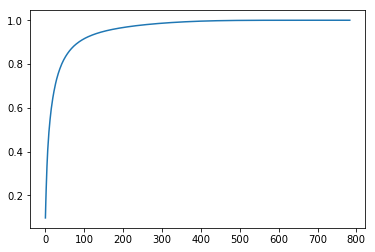

Performing logistic regression...


In [7]:
X, Y, _, _ = get_transformed_data()
X = X[:, :300]

# normalize X first
mu = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mu) / std

print("Performing logistic regression...")
Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]

N, D = Xtrain.shape
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

In [8]:
# 1. full
W = np.random.randn(D, 10) / 28 # propto sqrt dimensionality
b = np.zeros(10)
LL = []
lr = 0.0001
reg = 0.01
t0 = datetime.now()
for i in range(200):
    p_y = forward(Xtrain, W, b)

    W += lr*(gradW(Ytrain_ind, p_y, Xtrain) - reg*W)
    b += lr*(gradb(Ytrain_ind, p_y) - reg*b)
        
    p_y_test = forward(Xtest, W, b)
    ll = cost(p_y_test, Ytest_ind)
    LL.append(ll)
    if i % 20 == 0:
        err = error_rate(p_y_test, Ytest)
        print("Cost at iteration {}: {:.6f}".format(i, ll))
        print("Error rate:", err)
p_y = forward(Xtest, W, b)
print("Final error rate:", error_rate(p_y, Ytest))
print("Elapsted time for full GD:", datetime.now() - t0)

Cost at iteration 0: 896.171054
Error rate: 0.183
Cost at iteration 20: 355.944290
Error rate: 0.089
Cost at iteration 40: 332.857572
Error rate: 0.087
Cost at iteration 60: 323.638876
Error rate: 0.083
Cost at iteration 80: 318.451802
Error rate: 0.084
Cost at iteration 100: 315.031541
Error rate: 0.083
Cost at iteration 120: 312.565020
Error rate: 0.084
Cost at iteration 140: 310.682691
Error rate: 0.084
Cost at iteration 160: 309.189620
Error rate: 0.085
Cost at iteration 180: 307.971810
Error rate: 0.084
Final error rate: 0.084
Elapsted time for full GD: 0:00:23.731755


In [20]:
# 2. stochastic
W = np.random.randn(D, 10) / 28
b = np.zeros(10)
LL_stochastic = []
lr = 0.0001
reg = 0.01

t0 = datetime.now()
for i in range(3): # takes very long since we're computing cost for 41k samples
    tmpX, tmpY = shuffle(Xtrain, Ytrain_ind)
    for n in range(N): # shortcut so it won't take so long...
        x = tmpX[n,:].reshape(1,D)
        y = tmpY[n,:].reshape(1,10)
        p_y = forward(x, W, b)
        
        W += lr*(gradW(y, p_y, x) - reg*W)
        b += lr*(gradb(y, p_y) - reg*b)

        p_y_test = forward(Xtest, W, b)
        ll = cost(p_y_test, Ytest_ind)
        LL_stochastic.append(ll)

        if i%2==0 and n==N:
            err = error_rate(p_y_test, Ytest)
            print("Cost at iteration {}: {:.6f}".format(i, ll))
            print("Error rate:", err)
p_y = forward(Xtest, W, b)
print("Final error rate:", error_rate(p_y, Ytest))
print("Elapsted time for SGD:", datetime.now() - t0)

Final error rate: 0.125
Elapsted time for SGD: 0:04:13.804777


In [16]:
# 3. batch
W = np.random.randn(D, 10) / 28
b = np.zeros(10)
LL_batch = []
lr = 0.0001
reg = 0.01
batch_sz = 500
n_batches = N // batch_sz

t0 = datetime.now()
for i in range(60):
    tmpX, tmpY = shuffle(Xtrain, Ytrain_ind)
    for j in range(n_batches):
        x = tmpX[j*batch_sz:(j*batch_sz + batch_sz),:]
        y = tmpY[j*batch_sz:(j*batch_sz + batch_sz),:]
        p_y = forward(x, W, b)

        W += lr*(gradW(y, p_y, x) - reg*W)
        b += lr*(gradb(y, p_y) - reg*b)

        p_y_test = forward(Xtest, W, b)
        ll = cost(p_y_test, Ytest_ind)
        LL_batch.append(ll)
        if i % 10 == 0 and j==0:
            err = error_rate(p_y_test, Ytest)
            print("Cost at iteration {}: {:.6f}".format(i, ll))
            print("Error rate:", err)
p_y = forward(Xtest, W, b)
print("Final error rate:", error_rate(p_y, Ytest))
print("Elapsted time for batch GD:", datetime.now() - t0)

Cost at iteration 0: 2441.015998
Error rate: 0.875
Cost at iteration 10: 406.950025
Error rate: 0.096
Cost at iteration 20: 360.338411
Error rate: 0.089
Cost at iteration 30: 343.425575
Error rate: 0.087
Cost at iteration 40: 334.422790
Error rate: 0.085
Cost at iteration 50: 328.454865
Error rate: 0.086
Final error rate: 0.084
Elapsted time for batch GD: 0:00:18.241690


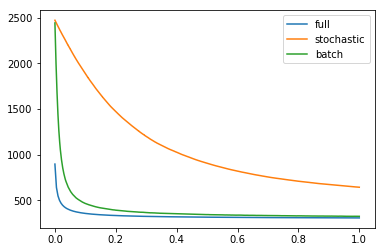

In [21]:
x1 = np.linspace(0, 1, len(LL))
plt.plot(x1, LL, label="full")

x2 = np.linspace(0, 1, len(LL_stochastic))
plt.plot(x2, LL_stochastic, label="stochastic")

x3 = np.linspace(0, 1, len(LL_batch))
plt.plot(x3, LL_batch, label="batch")

plt.legend()
plt.show()